In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()
display(data.head(4))

# Split data in train snd backtest
# ==============================================================================
n_backtest = 36*3  # Last 9 years are used for backtest
data_train = data[:-n_backtest]
data_backtest = data[-n_backtest:]

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


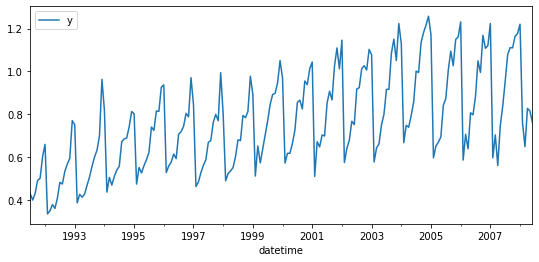

In [4]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax)
ax.legend();

## Backtest

In [5]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 96
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [6]:
print(f"Error backtest: {metric}")

Error backtest: [0.00726621]


In [7]:
print(predictions_backtest.head(4).to_markdown())

|                     |     pred |
|:--------------------|---------:|
| 1999-07-01 00:00:00 | 0.712336 |
| 1999-08-01 00:00:00 | 0.750542 |
| 1999-09-01 00:00:00 | 0.802371 |
| 1999-10-01 00:00:00 | 0.806941 |


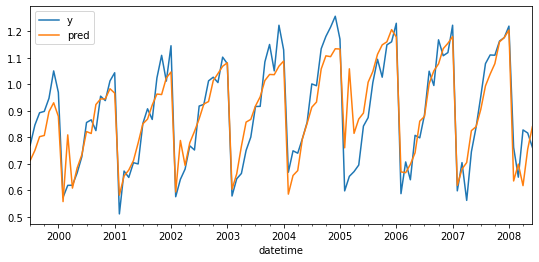

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

## Backtest with prediction intervals

In [9]:
# Backtest forecaster
# ==============================================================================

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    interval   = [5, 95],
                                    n_boot     = 500,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 96
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [10]:
print(f"Backtest error: {metric}")

Backtest error: [0.00779128]


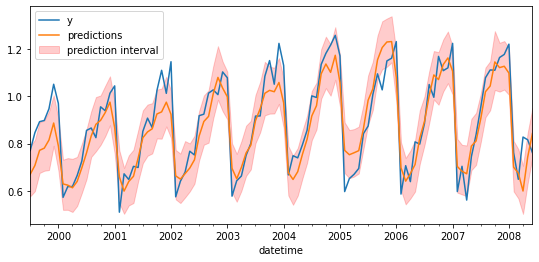

In [11]:
fig, ax=plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax, label='test')
predictions_backtest.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_backtest.index,
    predictions_backtest.iloc[:, 1],
    predictions_backtest.iloc[:, 2],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();

## Predictions on training data

Predictions on training data can be obtained either by using the `backtesting_forecaster()` function or by accessing the `predict()` method of the regressor stored inside the forecaster object.

### Predict using backtesting_forecaster()

A trained forecaster is needed.

In [12]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

forecaster.fit(y=data['y'])

Set arguments `initial_train_size = None` and `refit = False` to perform backtesting using the already trained forecaster. 

In [13]:
# Backtest train data
# ==============================================================================
metric, predictions_train = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = data['y'],
                                initial_train_size = None,
                                steps      = 1,
                                metric     = 'mean_squared_error',
                                refit      = False,
                                verbose    = False
                           )

print(f"Backtest training error: {metric}")

Backtest training error: [0.00053925]


In [14]:
predictions_train.head(4)

,pred
1992-10-01,0.553611
1992-11-01,0.568324
1992-12-01,0.735167
1993-01-01,0.723217


The first 15 observations are not predicted since they are needed to create the lags used as predictors.

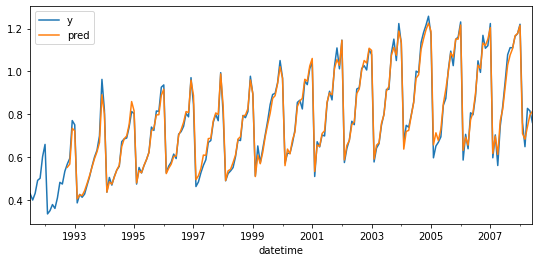

In [15]:
# Plot training predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.plot(ax=ax)
predictions_train.plot(ax=ax)
ax.legend();

### Predict using the internal regressor¶

In [16]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

forecaster.fit(y=data['y'])


In [17]:
# Create training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(
            y = data['y'], 
            exog = None
       )

Using the internal regressor only allows predicting one step.

In [18]:
# Predict using the internal regressor
# ==============================================================================
forecaster.regressor.predict(X)[:4]

array([0.55361079, 0.56832448, 0.73516725, 0.72321715])

## Backtest with exogenous variables

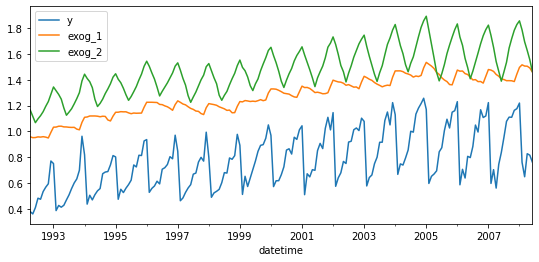

In [19]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Split data in train snd backtest
# ==============================================================================
n_backtest = 36*3  # Last 9 years are used for backtest
data_train = data[:-n_backtest]
data_backtest = data[-n_backtest:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [20]:
# Backtest forecaster exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1992-04-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [21]:
print(f"Backtest error with exogenous variables: {metric}")

Backtest error with exogenous variables: [0.00683408]


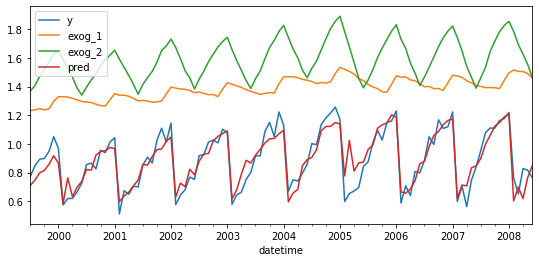

In [22]:
fig, ax = plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();